In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
import altair as alt
from scipy import stats

import scipy.stats as stats
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn import metrics 
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_absolute_error,  mean_absolute_percentage_error, mean_squared_error, r2_score
import xgboost
import optuna
from datetime import datetime, timedelta, date
import datetime
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import itertools

from multiprocessing.dummy import Pool as ThreadPool

from pandas.tseries.offsets import MonthEnd

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

%load_ext autotime

time: 0 ns (started: 2024-02-14 20:07:27 +02:00)


In [2]:
#displaying maximun rows and cloumns 

# display all columns of the dataframe
pd.options.display.max_columns = None

# display all rows of the dataframe
pd.options.display.max_rows = None

# Set the plot size
plt.rcParams['figure.figsize'] = [12, 8]  

time: 0 ns (started: 2024-02-14 20:07:27 +02:00)


In [3]:
# read data

path_campaign = r"\Users\Oleksandr.Bielov\Desktop\\Marketing_campaign\\marketing_campaign_start_dataset.csv"
path_country_add = r"/Users/Oleksandr.Bielov/Desktop//Marketing_campaign/addition_info.xlsx"
path_product = r"/Users/Oleksandr.Bielov/Desktop//Marketing_campaign/dimProduct.xlsx"
path_coef = r"/Users/Oleksandr.Bielov/Desktop//Marketing_campaign/dimCoef.xlsx"


df = pd.read_csv(path_campaign)
df_country = pd.read_excel(path_country_add)
df_product = pd.read_excel(path_product)
df_coef = pd.read_excel(path_coef)


time: 657 ms (started: 2024-02-14 20:07:29 +02:00)


In [4]:
# Display the first 5 rows of the dataframe
df.head(5)

,Campaign_ID,Company,Campaign_Type,Target_Audience,Duration,Channel_Used,Conversion_Rate,Acquisition_Cost,ROI,Location,Language,Clicks,Impressions,Engagement_Score,Customer_Segment,Date
0,1,Innovate Industries,Email,Men 18-24,30 days,Google Ads,0.04,"$16,174.00",6.29,Chicago,Spanish,506,1922,6,Health & Wellness,2021-01-01
1,2,NexGen Systems,Email,Women 35-44,60 days,Google Ads,0.12,"$11,566.00",5.61,New York,German,116,7523,7,Fashionistas,2021-01-02
2,3,Alpha Innovations,Influencer,Men 25-34,30 days,YouTube,0.07,"$10,200.00",7.18,Los Angeles,French,584,7698,1,Outdoor Adventurers,2021-01-03
3,4,DataTech Solutions,Display,All Ages,60 days,YouTube,0.11,"$12,724.00",5.55,Miami,Mandarin,217,1820,7,Health & Wellness,2021-01-04
4,5,NexGen Systems,Email,Men 25-34,15 days,YouTube,0.05,"$16,452.00",6.50,Los Angeles,Mandarin,379,4201,3,Health & Wellness,2021-01-05


time: 15 ms (started: 2024-02-14 20:07:30 +02:00)


In [5]:
# no of rows and columns 
df.shape

(200000, 16)

time: 0 ns (started: 2024-02-14 20:07:31 +02:00)


In [6]:
#clumns in dataset 
df.columns

Index(['Campaign_ID', 'Company', 'Campaign_Type', 'Target_Audience',
       'Duration', 'Channel_Used', 'Conversion_Rate', 'Acquisition_Cost',
       'ROI', 'Location', 'Language', 'Clicks', 'Impressions',
       'Engagement_Score', 'Customer_Segment', 'Date'],
      dtype='object')

time: 0 ns (started: 2024-02-14 20:07:32 +02:00)


In [7]:
#type for each columns in datasets
df_coef.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country             30 non-null     object 
 1   Campaign_Channel    30 non-null     object 
 2   Campaign_cost_coef  30 non-null     float64
 3   Impressions_coef    30 non-null     float64
 4   Clicks_coef         30 non-null     float64
 5   Conversion_coef     30 non-null     float64
 6   Engagement_coef     30 non-null     float64
dtypes: float64(5), object(2)
memory usage: 1.8+ KB
time: 15 ms (started: 2024-02-14 20:07:33 +02:00)


In [8]:
# rename column in df_product for correct join
df_product = df_product.rename(columns={'Product ID': 'Product_ID'})

time: 0 ns (started: 2024-02-14 20:07:34 +02:00)


In [9]:
# Calculate the total count of missing values for each variable
total_missing = df.isnull().sum()

# Calculate the percentage of missing values for each variable
percent_missing = (total_missing * 100) / df.isnull().count()
percent_missing = percent_missing.round(decimals=0)  # Round the percentage values

# Create a DataFrame to store the missing data information
missing_data = pd.DataFrame({
    'Total': total_missing,
    'Percentage of Missing Values': percent_missing,
    'Type': df.dtypes
})

# Sort the DataFrame based on the total count of missing values in descending order
missing_data = missing_data.sort_values(by='Total', ascending=False)

missing_data

,Total,Percentage of Missing Values,Type
Campaign_ID,0,0.0,int64
Company,0,0.0,object
Campaign_Type,0,0.0,object
Target_Audience,0,0.0,object
Duration,0,0.0,object
Channel_Used,0,0.0,object
Conversion_Rate,0,0.0,float64
Acquisition_Cost,0,0.0,object
ROI,0,0.0,float64
Location,0,0.0,object


time: 125 ms (started: 2024-02-14 20:07:35 +02:00)


In [10]:
# Remove dollar sign and commas from 'Acquisition_Cost' column and convert it to float
df['Acquisition_Cost'] = df['Acquisition_Cost'].str.replace('$', '').str.replace(',', '').astype(float)

# Convert 'Duration' column to numeric by extracting the number of days
df['Duration'] = df['Duration'].str.extract('(\d+)').astype(int)

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Convert 'Campaign_Type' column to categorical
df['Company'] = df['Company'].astype('category')

# Convert 'Target_Audience' column to categorical
df['Target_Audience'] = df['Target_Audience'].astype('category')

# Convert 'Channel_Used' column to categorical
df['Channel_Used'] = df['Channel_Used'].astype('category')

# Convert 'Language' column to categorical
df['Language'] = df['Language'].astype('category')

# Convert 'Customer_Segment' column to categorical
df['Customer_Segment'] = df['Customer_Segment'].astype('category')

time: 781 ms (started: 2024-02-14 20:07:36 +02:00)


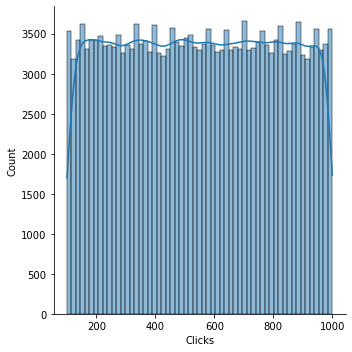

time: 765 ms (started: 2024-02-14 20:07:37 +02:00)


In [11]:
# распределение цен "price"
sns.displot(df["Clicks"], kde=True)

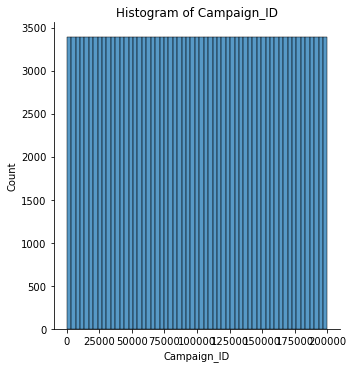

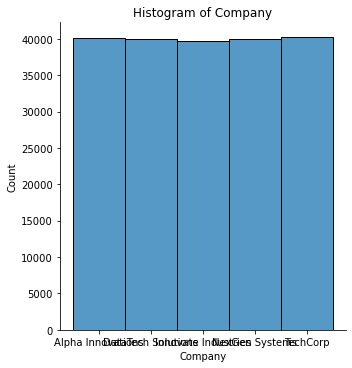

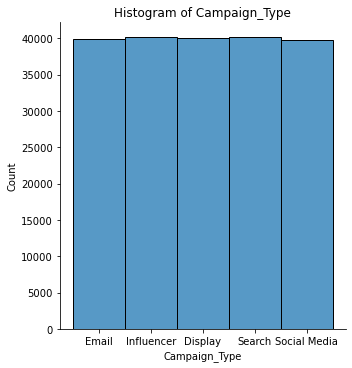

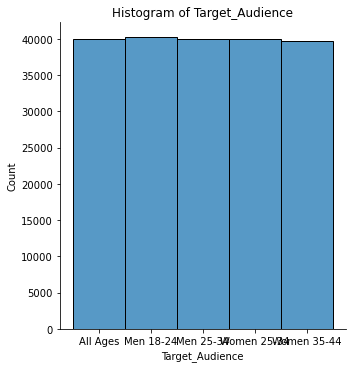

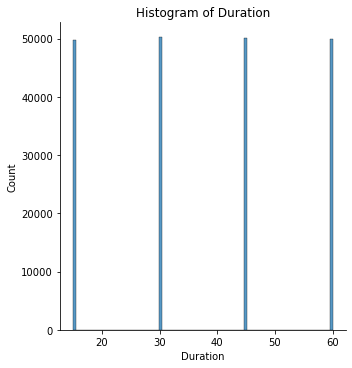

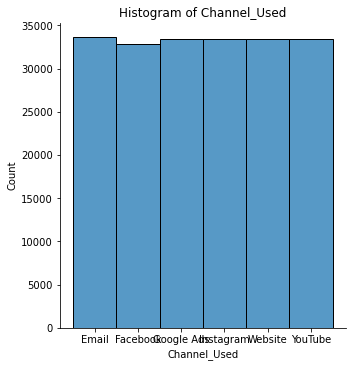

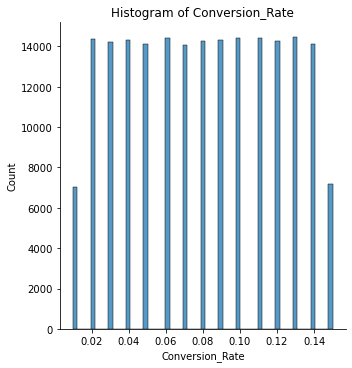

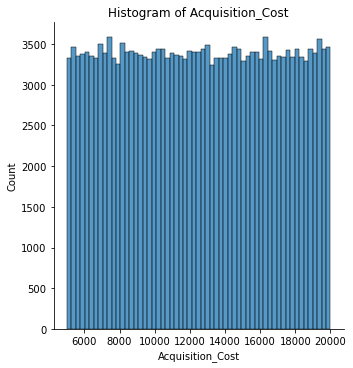

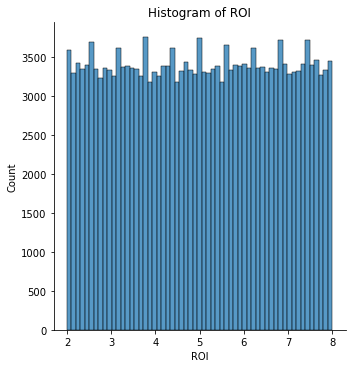

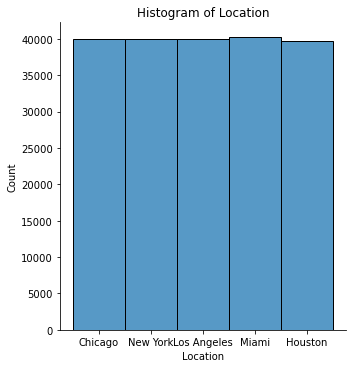

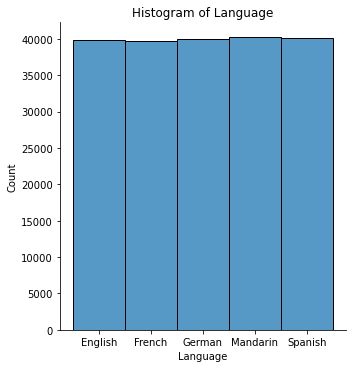

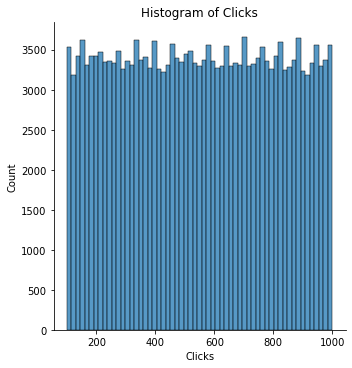

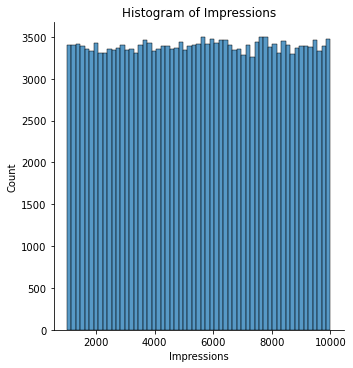

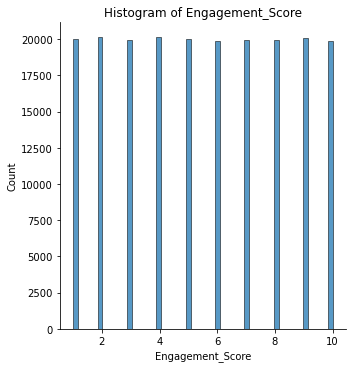

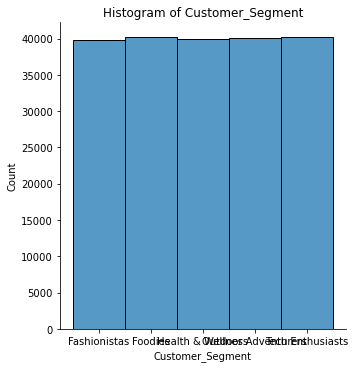

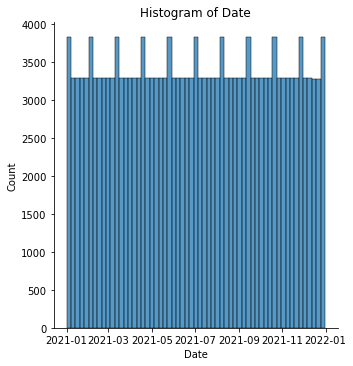

time: 5.02 s (started: 2024-02-14 20:07:39 +02:00)


In [12]:
for feature in df.columns:
    sns.displot(df[feature])
    plt.title('Histogram of {}'.format(feature))
    plt.show()

In [13]:
# create new dataset
df_FE = df.drop(['Language'], axis=1)

df_FE['Date'] = pd.to_datetime(df_FE['Date'], errors='coerce')

time: 16 ms (started: 2024-02-14 20:07:44 +02:00)


In [14]:
#normal distribution 'Clicks'
# Fit a normal distribution to the data
normal_distribution_Clicks = stats.norm(loc=df_FE['Clicks'].mean(), scale=df_FE['Clicks'].std())

# Transform data to follow a normal distribution
transformed_values_Clicks = normal_distribution_Clicks.ppf(stats.rankdata(df_FE['Clicks']) / (len(df_FE) + 1))

# Shift the transformed values to ensure they are greater than 0
min_value = transformed_values_Clicks.min()
if min_value <= 0:
    shift = 1 - min_value
    transformed_values_Clicks += shift
    
#normal distribution 'Impressions'
# Fit a normal distribution to the data
normal_distribution_Impressions = stats.norm(loc=df_FE['Impressions'].mean(), scale=df_FE['Impressions'].std())

# Transform data to follow a normal distribution
transformed_values_Impressions = normal_distribution_Impressions.ppf(stats.rankdata(df_FE['Impressions']) / (len(df_FE) + 1))

# Shift the transformed values to ensure they are greater than 0
min_value_imp = transformed_values_Impressions.min()
if min_value_imp <= 0:
    shift_imp = 1 - min_value_imp
    transformed_values_Impressions += shift_imp

time: 78 ms (started: 2024-02-14 20:07:44 +02:00)


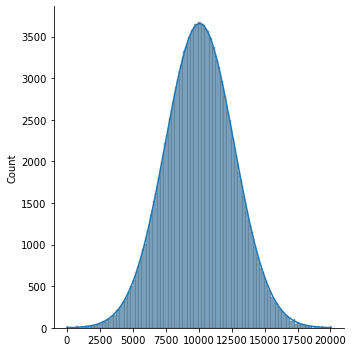

time: 1.09 s (started: 2024-02-14 20:07:44 +02:00)


In [15]:
sns.displot(transformed_values_Impressions, kde=True)

In [16]:
df_FE['Click_norm'] = transformed_values_Clicks.round(0)
df_FE['Impressions_norm'] = transformed_values_Impressions.round(0)


time: 16 ms (started: 2024-02-14 20:07:46 +02:00)


In [17]:
import calendar
import random
random.seed(1)

# Define a function to change the date based on a condition (date + pd.offsets.MonthEnd(0)).day)
def change_date(date):
    if date.day <= 10:
        return date.replace(year=2021, month = date.month, day = random.randint(1, calendar.monthrange(2021, date.month)[1]))
    elif date.day > 10 and date.day <= 20:
        return date.replace(year=2022, month = date.month, day = random.randint(1, calendar.monthrange(2022, date.month)[1]))
    else: 
        return date.replace(year=2023, month = date.month, day = random.randint(1, calendar.monthrange(2023, date.month)[1]))

time: 0 ns (started: 2024-02-14 20:07:54 +02:00)


In [18]:
# split current 2021 year to 21-23
df_FE['NewDate'] = df_FE['Date'].apply(change_date)

time: 1.66 s (started: 2024-02-14 20:07:55 +02:00)


In [19]:
df_FE['NewDate'] = pd.to_datetime(df_FE['NewDate'], errors='coerce')


time: 16 ms (started: 2024-02-14 20:07:57 +02:00)


In [20]:
# drop all Company except 'Innovate Industries'
df_FE = df_FE[(df_FE.Company == 'Innovate Industries')] 

#drop Company column
df_FE = df_FE.drop(['Company'], axis=1)

time: 15 ms (started: 2024-02-14 20:07:59 +02:00)


In [21]:
# drop Campaign_Type Influencer
df_FE = df_FE[(df_FE.Campaign_Type != 'Influencer')]

# drop Customer_Segment Foodies and Health & Wellness
df_FE = df_FE[(df_FE.Customer_Segment != 'Foodies')]
df_FE = df_FE[(df_FE.Customer_Segment != 'Health & Wellness')]

time: 16 ms (started: 2024-02-14 20:08:02 +02:00)


In [22]:
# replace Location
df_FE.loc[df_FE['Location'] == 'Chicago', 'Location'] = 'Germany'
df_FE.loc[df_FE['Location'] == 'New York', 'Location'] = 'United Kingdom'
df_FE.loc[df_FE['Location'] == 'Houston', 'Location'] = 'France'
df_FE.loc[df_FE['Location'] == 'Miami', 'Location'] = 'Spain'
df_FE.loc[df_FE['Location'] == 'Los Angeles', 'Location'] = 'South Africa'

time: 15 ms (started: 2024-02-14 20:08:04 +02:00)


In [23]:
# replace Customer_Segment
df_FE['Customer_Segment'] = df_FE['Customer_Segment'].astype(str)

df_FE.loc[df_FE['Customer_Segment'] == 'Fashionistas', 'Customer_Segment'] = 'Clothing'
df_FE.loc[df_FE['Customer_Segment'] == 'Outdoor Adventurers', 'Customer_Segment'] = 'Shoes'
df_FE.loc[df_FE['Customer_Segment'] == 'Tech Enthusiasts', 'Customer_Segment'] = 'Accessories'

time: 15 ms (started: 2024-02-14 20:08:05 +02:00)


In [24]:
# rename columns

df_FE = df_FE.rename(columns={'Location': 'Country', 
                              'Customer_Segment': 'Product_Category',
                              'Channel_Used' : 'Campaign_Channel',
                              'Acquisition_Cost': 'Campaign_Cost',
                              'ROI' : 'ROMI'})

time: 0 ns (started: 2024-02-14 20:08:06 +02:00)


In [25]:
def change_month(date):
    if date.month > 6:
          return date.replace(year=date.year, month = date.month - 6, day = random.randint(1, calendar.monthrange(date.year, date.month-6)[1]))

    else: 
          return date.replace(year=date.year, month = date.month + 6, day = random.randint(1, calendar.monthrange(date.year, date.month+6)[1]))


time: 0 ns (started: 2024-02-14 20:08:08 +02:00)


In [26]:
df_FE.loc[df_FE['Country'] == 'South Africa', 'NewDate'] = df_FE['NewDate'].apply(change_month)

time: 219 ms (started: 2024-02-14 20:08:18 +02:00)


In [27]:
# split Target_Audience
df_FE[['Target_Gender', 'Target_Age']] = df_FE['Target_Audience'].str.split(expand=True)
df_FE.loc[df_FE['Target_Age'] == 'Ages', 'Target_Age'] = 'All'

df_FE = df_FE.drop(['Target_Audience'], axis=1)

time: 15 ms (started: 2024-02-14 20:08:20 +02:00)


In [28]:
# add Product_ID
random.seed(1)

df_FE.loc[df_FE['Product_Category'] == 'Clothing', 'Product_ID'] = random.randint(1, 21)
df_FE.loc[df_FE['Product_Category'] == 'Shoes', 'Product_ID'] = random.randint(22, 36)
df_FE.loc[df_FE['Product_Category'] == 'Accessories', 'Product_ID'] = random.randint(37, 48)


time: 0 ns (started: 2024-02-14 20:08:21 +02:00)


In [29]:
# add new features

df_FE = df_FE.merge(df_product, on='Product_ID', how='left')
df_FE = df_FE.merge(df_country, on='Country', how='left')
df_FE = df_FE.merge(df_coef, on=['Country', 'Campaign_Channel'], how='left')

time: 47 ms (started: 2024-02-14 20:08:23 +02:00)


In [31]:
# # Specify the folder path where you want to save the CSV file
# folder_path_temp = r"\Users\Oleksandr.Bielov\Desktop\\Marketing_campaign\\"

# # Specify the file name for the CSV file
# file_name_ = 'output_temp.csv'

# # Construct the full file path
# file_path_ = folder_path_temp + file_name_

# df_FE.to_csv(file_path_, index=False)

time: 843 ms (started: 2024-02-14 15:20:17 +02:00)


In [258]:
# path_temp = r"\Users\Oleksandr.Bielov\Desktop\\Marketing_campaign\\output_temp.csv"

# df_FE = pd.read_csv(path_temp)

# df_FE['NewDate'] = pd.to_datetime(df_FE['NewDate'], errors='coerce')
# df_FE['Date'] = pd.to_datetime(df_FE['Date'], errors='coerce')

time: 78 ms (started: 2024-02-14 19:40:21 +02:00)


In [30]:
# add random ROMI
np.random.seed(2020)
# np.random.seed(12)

random_values = np.arange(0.8, 3.0, 0.2)

df_FE['ROMI'] = pd.DataFrame(np.random.choice(random_values, len(df_FE)))

time: 0 ns (started: 2024-02-14 20:08:30 +02:00)


In [31]:
# correction value with coef

df_FE['Campaign_Cost']=df_FE['Campaign_Cost']*df_FE['Campaign_cost_coef']*df_FE['GDP_coef']
df_FE['Impressions_norm']=df_FE['Impressions_norm']*df_FE['Impressions_coef']* df_FE['Population_coef']
df_FE['Click_norm']=df_FE['Click_norm']*df_FE['Clicks_coef']* df_FE['Population_coef']
df_FE['Conversion_Rate']=(df_FE['Conversion_Rate']*df_FE['Conversion_coef']).round(2)


time: 0 ns (started: 2024-02-14 20:08:32 +02:00)


In [32]:
df_FE['Campaign_Cost'] = df_FE['Campaign_Cost']/100

# dif proportion for Product Category
df_FE.loc[df_FE['Product Category'] == 'Shoes', 'Campaign_Cost'] = df_FE['Campaign_Cost']*0.6
df_FE.loc[df_FE['Product Category'] == 'Accessories', 'Campaign_Cost'] = df_FE['Campaign_Cost']*0.8
df_FE.loc[df_FE['Product Category'] == 'Clothing', 'Campaign_Cost'] = df_FE['Campaign_Cost']*1

df_FE.loc[df_FE['Duration'] == 15, 'Campaign_Cost'] = df_FE['Campaign_Cost']*1.3
df_FE.loc[df_FE['Duration'] == 30, 'Campaign_Cost'] = df_FE['Campaign_Cost']*1.1
df_FE.loc[df_FE['Duration'] == 30, 'Campaign_Cost'] = df_FE['Campaign_Cost']*0.9
df_FE.loc[df_FE['Duration'] == 60, 'Campaign_Cost'] = df_FE['Campaign_Cost']*0.7


time: 0 ns (started: 2024-02-14 20:08:35 +02:00)


In [33]:
df_FE.loc[df_FE['NewDate'].dt.year == 2021, 'Campaign_Cost'] = df_FE['Campaign_Cost']*30
df_FE.loc[df_FE['NewDate'].dt.year == 2022, 'Campaign_Cost'] = df_FE['Campaign_Cost']*35
df_FE.loc[df_FE['NewDate'].dt.year == 2023, 'Campaign_Cost'] = df_FE['Campaign_Cost']*40


df_FE.loc[df_FE['NewDate'].dt.year == 2021, 'ROMI'] = df_FE['ROMI']*1.31 #/100
df_FE.loc[df_FE['NewDate'].dt.year == 2022, 'ROMI'] = df_FE['ROMI']*1.26 #/100
df_FE.loc[df_FE['NewDate'].dt.year == 2023, 'ROMI'] = df_FE['ROMI']*1.18 #/100

time: 16 ms (started: 2024-02-14 20:08:40 +02:00)


In [34]:
# tune Campaign_Cost for Sales scale
df_FE.loc[(df_FE['Product Category'] == 'Clothing') & (df_FE['Country'] == 'South Africa'), 'Campaign_Cost'] = df_FE['Campaign_Cost']/3

df_FE.loc[(df_FE['Product Category'] == 'Clothing') & (df_FE['Country'] == 'Germany'), 'Campaign_Cost'] = df_FE['Campaign_Cost']/4

df_FE.loc[df_FE['Product Category'] == 'Clothing', 'ROMI'] = df_FE['ROMI']*0.5


time: 16 ms (started: 2024-02-14 20:08:41 +02:00)


In [35]:
# tune Campaign_Cost < 100$
df_FE.loc[df_FE['Campaign_Cost']<100, 'Campaign_Cost'] = df_FE['Campaign_Cost']*100

time: 0 ns (started: 2024-02-14 20:08:43 +02:00)


In [36]:

df_FE['Campaign_Cost'] = (df_FE['Campaign_Cost'] // 100) * 100
df_FE['Revenue'] = (df_FE['ROMI'] + 1) * df_FE['Campaign_Cost']

# add sesonality

north_hemi_highmonth = [5,6,7]
south_hemi_highmonth = [11,12,1]
df_FE['Revenue'] = np.where((df_FE['NewDate'].dt.month.isin(north_hemi_highmonth)) & (df_FE['Country'] != 'South Africa'), df_FE['Revenue']*1.2, df_FE['Revenue'])
df_FE['Revenue'] = np.where((df_FE['NewDate'].dt.month.isin(south_hemi_highmonth)) & (df_FE['Country'] == 'South Africa'), df_FE['Revenue']*1.2, df_FE['Revenue'])


time: 16 ms (started: 2024-02-14 20:08:45 +02:00)


In [37]:
# rounded values
# df_FE['Campaign_Cost'] = (df_FE['Campaign_Cost'] // 10) * 10
df_FE['Click_norm'] = df_FE['Click_norm'].round(0).astype(int)
df_FE['Impressions_norm'] = df_FE['Impressions_norm'].round(0)

time: 0 ns (started: 2024-02-14 20:08:47 +02:00)


In [38]:
# clear case when clicks > impression
df_FE.loc[df_FE['Click_norm'] > df_FE['Impressions_norm'], 'Impressions_norm'] = df_FE['Click_norm'] 
df_FE.loc[df_FE['Click_norm'] == df_FE['Impressions_norm'], 'Impressions_norm'] = df_FE['Impressions_norm']*3
df_FE.loc[df_FE['Click_norm'] == 0, 'Click_norm'] = df_FE['Impressions_norm']*0.3
df_FE['Click_norm'] = df_FE['Click_norm'].round(0)

# add mew metrics CTR - Click Through Rate and CPC - Cost per Click + update ROMI
df_FE['Revenue'] = (df_FE['Revenue']//df_FE['Price (USD)'])*df_FE['Price (USD)']
df_FE['CTR'] = df_FE['Click_norm']/df_FE['Impressions_norm']
df_FE['CPC'] = df_FE['Campaign_Cost'] / df_FE['Click_norm']
df_FE['ROMI'] = (df_FE['Revenue'] - df_FE['Campaign_Cost']) / df_FE['Campaign_Cost']


time: 15 ms (started: 2024-02-14 20:08:48 +02:00)


In [39]:
df_FE.head(5)

,Campaign_ID,Campaign_Type,Duration,Campaign_Channel,Conversion_Rate,Campaign_Cost,ROMI,Country,Clicks,Impressions,Engagement_Score,Product_Category,Date,Click_norm,Impressions_norm,NewDate,Target_Gender,Target_Age,Product_ID,Product,Product Subcategory,Product Category,Weight (KG) per Package,Volume (M3) per Package,Price (USD),Population,Population_coef,GDP,GDP_coef,Campaign_cost_coef,Impressions_coef,Clicks_coef,Conversion_coef,Engagement_coef,Revenue,CTR,CPC
0,17,Display,45,Website,0.03,500.0,0.300000,France,931,2488,3,Clothing,2021-01-17,407.0,2503.0,2022-01-04,Women,35-44,5.0,Puffer Jacket,Jackets,Clothing,0.76,0.0045,130,67.75,0.83,2716,0.7,0.4,0.4,0.4,0.4,0.4,650.0,0.162605,1.228501
1,31,Search,45,Instagram,0.05,2000.0,2.825000,France,512,4837,4,Accessories,2021-01-31,482.0,5565.0,2023-01-24,Men,25-34,38.0,Crossbody Bag,Bags,Accessories,0.23,0.0020,45,67.75,0.83,2716,0.7,0.7,0.7,0.7,0.7,0.7,7650.0,0.086613,4.149378
2,39,Search,30,Instagram,0.14,4500.0,1.830000,Germany,663,9473,10,Accessories,2021-02-08,1222.0,18376.0,2021-02-01,Men,25-34,38.0,Crossbody Bag,Bags,Accessories,0.23,0.0020,45,83.20,1.00,3862,1.0,1.3,1.3,1.3,1.3,1.3,12735.0,0.066500,3.682488
3,40,Search,45,Google Ads,0.07,1000.0,1.210000,Germany,268,5495,6,Clothing,2021-02-09,563.0,9052.0,2021-02-21,Men,18-24,5.0,Puffer Jacket,Jackets,Clothing,0.76,0.0045,130,83.20,1.00,3862,1.0,0.9,0.9,0.9,0.9,0.9,2210.0,0.062196,1.776199
4,43,Display,60,Instagram,0.06,900.0,0.877778,France,598,8637,5,Clothing,2021-02-12,518.0,7407.0,2022-02-13,Men,25-34,5.0,Puffer Jacket,Jackets,Clothing,0.76,0.0045,130,67.75,0.83,2716,0.7,0.7,0.7,0.7,0.7,0.7,1690.0,0.069934,1.737452


time: 15 ms (started: 2024-02-14 20:08:51 +02:00)


In [40]:
df_FE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18904 entries, 0 to 18903
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Campaign_ID              18904 non-null  int64         
 1   Campaign_Type            18904 non-null  object        
 2   Duration                 18904 non-null  int32         
 3   Campaign_Channel         18904 non-null  object        
 4   Conversion_Rate          18904 non-null  float64       
 5   Campaign_Cost            18904 non-null  float64       
 6   ROMI                     18904 non-null  float64       
 7   Country                  18904 non-null  object        
 8   Clicks                   18904 non-null  int64         
 9   Impressions              18904 non-null  int64         
 10  Engagement_Score         18904 non-null  int64         
 11  Product_Category         18904 non-null  object        
 12  Date                     18904 n

In [41]:
# drop unnecessary columns
df_FE = df_FE.drop(['Date', 
                    'Campaign_Type', 
                    'Impressions', 
                    'Clicks',
                    'Engagement_Score',
                    'Weight (KG) per Package',
                    'Volume (M3) per Package',
                    'Population_coef', 
                    'GDP_coef', 
                    'Campaign_cost_coef', 
                    'Impressions_coef', 
                    'Clicks_coef', 
                    'Conversion_coef', 
                    'Engagement_coef'], axis=1)

time: 0 ns (started: 2024-02-14 20:08:58 +02:00)


In [42]:
df_FE = df_FE.rename(columns={'Impressions_norm': 'Impressions', 
                              'Click_norm': 'Clicks',
                              'NewDate' : 'StartDate'})

time: 0 ns (started: 2024-02-14 20:09:00 +02:00)


In [44]:

# Specify the folder path where you want to save the CSV file
folder_path = r"\Users\Oleksandr.Bielov\Desktop\\Marketing_campaign\\"

# Specify the file name for the CSV file
file_name = 'Marketing_Dataset.csv'

# Construct the full file path
file_path = folder_path + file_name

df_FE.to_csv(file_path, index=False)

time: 344 ms (started: 2024-02-14 20:14:47 +02:00)
